This notebook implements a variation on Class Activation Maps as described in the original paper https://arxiv.org/abs/1512.04150 using a pretrained resnet50.

I am using [fastai v2](https://github.com/fastai/fastai_dev) which is currently being developed. From what I have seen, it is going to be amazing. I love how readable the code is and how much flexibility it affords.

The library is undergoing active development and the API is still bound to change. This notebook works with fastai v2 at this hash: 690ce6774916a2f366e27ff5d1d453df03c1e6f1. 

In [1]:
import sys
path_to_fastai_dev_local = '/home/radek/work/fastai_dev/dev' # <- change this to where you have fastai_dev

sys.path.append(path_to_fastai_dev_local)

In [2]:
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.vision.all import *
from local.vision.learner import *
from local.vision.models import *
from local.callback.all import *

import skimage

## From items to DataBunch (constructing the train and val sets)

In [3]:
source = 'data/112/train/'
items = get_image_files(source)

In [4]:
class Labeller():
    '''path to label, eg. path -> 0'''
    def __init__(self):
        self.df = pd.read_csv('data/train_labels_as_strings_with_label_class.csv')
        self.df.set_index('fn', inplace=True)
    def __call__(self, path):
        fn = path.name
        labels_txt = self.df.loc[fn].labels
        if labels_txt == ' ': return 0 # I do not care about the type of haemorrhage
        else: return 1                 # all I want is for regions of interest to light up

In [5]:
tfms = [PILImage.create, [Labeller()]]

ds_img_tfms = [ToTensor()]
dsrc = DataSource(items, tfms, filts=RandomSplitter()(items))

In [6]:
dsrc[1]

(<local.vision.core.PILImage image mode=RGB size=112x112 at 0x7F7C8D673860>, 0)

In [7]:
# %%time

# means, stds = [], []

# for batch in dbch.train_dl:
#     reshaped = batch[0].permute(1,0,2,3).reshape((3, -1))
#     means.append(reshaped.mean(1)), stds.append(reshaped.std(1))

# torch.stack(means).mean(0)

# torch.stack(stds).mean(0)

In [8]:
means = [0.1627, 0.1348, 0.1373]
st_devs = [0.2961, 0.2605, 0.1889]

dataset_stats = (means, st_devs)
dataset_stats = broadcast_vec(1, 4, *dataset_stats)

In [9]:
ds_img_tfms = [ToTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*dataset_stats)]

dbch = dsrc.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=128, num_workers=12)

## Building the model

In [10]:
def global_avg_pool(t):
    bs, cls, _, _ = t.shape
    return t.reshape(bs, cls, -1).mean(-1)

I am creating a model based on res18. I am using the very handy fastai function `create_body` which will give me a model without the classifier. I can then append my custom head onto it. Should the modifications end there, this could be very elegantly achieved using another very useful fastai feature - the Lambda layer).

The model could look something like this:

In [11]:
res18 = create_body(resnet18, True)
m = nn.Sequential(*res18, nn.Conv2d(512, 2, kernel_size=3, stride=1, padding=1), Lambda(global_avg_pool))

Will this be enough for our needs though? Let's see. Let's create a tensor in the shape of an image and see what output we get at the layer of interest, that is the global average pooling layer.

In [12]:
t = torch.rand(1, 3, 112, 112)

In [13]:
m[:8](t).shape

torch.Size([1, 512, 4, 4])

For an image of dimensions 112x112 we would get a heatmap of dimensionality 4x4. That is definitely too small for our needs.

I am happy to modify the model, trade some of it's discriminative power (but not too much hopefully) for higher resolution.

I assume we can safely cut off another segment from the top of the model. We will be dealing mostly with shapes so that might be a good thing to do either way.

In [14]:
res18 = create_body(resnet18, True)
m = nn.Sequential(*res18[:-1], nn.Conv2d(256, 2, kernel_size=3, stride=1, padding=1), Lambda(global_avg_pool))

In [15]:
m[:-2](t).shape

torch.Size([1, 256, 7, 7])

7x7 is better but we still probably can tweak the approach.

We could remove the max pooling layer from the beginning of the model, but I don't like this approach. This would make training the model much more computationally expensive as we move to bigger image sizes. This also does not seem like a good approach for taking full advantage of the pretraining of the models.

As you can infer from my writing, I am making a lot of decisions based on intuitions. Often times intuitions are wrong, so if you want to maximize your score in the competition, it would be actually best to experiment with different approaches.

Instead of making changes to the lower levels of the stack, let's grab a bigger model that hopefully will have more discriminative power even with more layers from the top cut off and let's see how we fare.

In [16]:
res50 = create_body(resnet50, True) # <- look how simple is this! :)

# here I am cutting one more layer from the top, res50[:-2] instead of res50[:-1]
m = nn.Sequential(*res50[:-2], nn.Conv2d(256, 2, kernel_size=3, stride=1, padding=1), Lambda(global_avg_pool))

In [17]:
m[:-2](t).shape

torch.Size([1, 512, 14, 14])

14x14 is probably something we can work with. The big question is, will we get enough discriminative performance from the model? I think anything above 93% accuracy on the validation set will be good enough.

Slight modification here. I want my architecture to consist of 3 modules - this way I can train with progressive unfreezing and discriminative learning rates.

In [18]:
m = nn.Sequential(
    res50[:-4],
    res50[-4:-2],
    nn.Sequential(
        nn.Conv2d(512, 2, kernel_size=3, stride=1, padding=1),
        Lambda(global_avg_pool)
    )
)

In [19]:
len(m)

3

The need for modifying the function below and for cutting the model manually will probably go away as the development of fastai v2 progresses. But it's actually nice that we can peer under the hood and define some of this functionality for us manually - a good learning experience.

v2 is extremely modular and makes defining functionality like below very approachable.

In [20]:
def trainable_params_mod(model): return L(trainable_params(mod) for mod in model)

In [21]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

In [22]:
learn = Learner(dbch, m, loss_func=CrossEntropyLossFlat(), metrics=[accuracy], opt_func=opt_func, splitter=trainable_params_mod)

## Training

In [23]:
learn.freeze_to(-1)

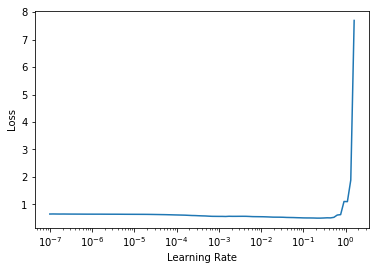

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.230605,0.188064,0.928966,07:02


In [26]:
learn.save('CAM-1')

In [27]:
learn.load('CAM-1')

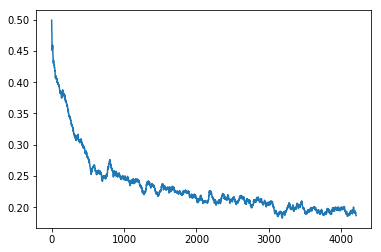

In [28]:
learn.recorder.plot_loss()

In [29]:
learn.freeze_to(-2)

In [32]:
learn.fit_one_cycle(2, [1e-3, 5e-4, 1e-4])

epoch,train_loss,valid_loss,accuracy,time
0,0.193985,0.177957,0.932066,08:04
1,0.162764,0.155142,0.940668,08:12


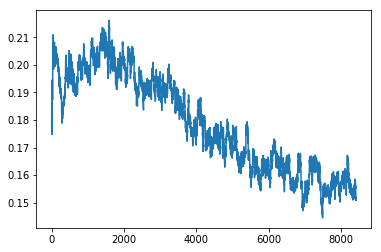

In [33]:
learn.recorder.plot_loss()

In [34]:
learn.save('CAM-2')

In [35]:
learn.load('CAM-2')

In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(1, [1e-4, 5e-5, 1e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.149260,0.153392,0.941713,08:10


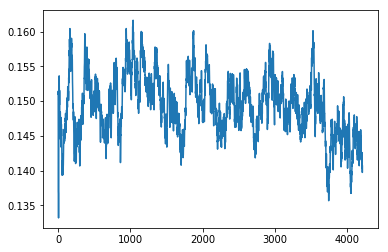

In [38]:
learn.recorder.plot_loss()

In [39]:
learn.save('CAM-3')

## Inference

Accuracy of above 94% sounds impressive, right? Unfortunately, the classes in the validation set are imbalanced, so it is really hard to say if the model is doing anything useful (there are significantly more negative than positive examples).

Let's look at numbers that are much more telling, that is the precision and recall.

In [40]:
learn.load('CAM-3')

In [41]:
learn.metrics += [Precision(), Recall()]
learn.validate()

[0.1533920019865036, 0.9417134523391724, 0.846755609460279, 0.7236214759535655]

The numbers don't look great by any means. I am hoping a lot of this can be chalked up to how small the images are. We are working with 112x112 images and moving to 224x224, a 4x increase, should hopefully help.

Nonetheless, our model has learned something, let's see what it does.

Setting model to eval mode - we don't want batchnorm running stats to be recalculated as we go.

In [43]:
learn.model.eval();

Let's grab a couple of predictions on the validation set where the model predicts the positive class with highest confidence. Hopefully this will make for interesting images.

In [44]:
preds, targs = learn.get_preds()

In [55]:
preds[:, 1].argsort(descending=True)[:4]

tensor([ 63576,  75776, 128340,  99764])

In [56]:
targs[[ 63576,  75776, 128340,  99764]] # the predictions are correct

tensor([1, 1, 1, 1])

The function below will take an image and modify it (cast it to a tensor, move it to the GPU, normalize) so that we can pass it through our model.

In [58]:
def img2t(img):
    t = ToTensor()(img)[None,:].cuda()
    t = ByteToFloatTensor()(t)
    return Normalize(*dataset_stats)(t)

In [59]:
img = learn.dbunch.valid_ds[63576][0]

In [60]:
img2t(img).shape

torch.Size([1, 3, 112, 112])

The below is a testament to Pytorch's flexibility. I am grabbing pieces of our trained model and using them to construct a new model, one that will take in an image and output a heatmap.

In [61]:
img2heatmap = nn.Sequential(learn.model[:2], learn.model[2][0]).cuda()

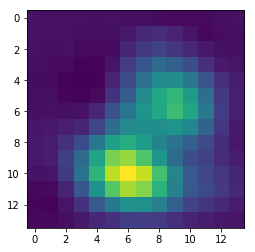

In [62]:
heatmap = img2heatmap(img2t(img).cuda())[0][1].detach().cpu()
plt.imshow(heatmap)

Remving negative activations and normalizing the heatmap to a 0 to 1 range.

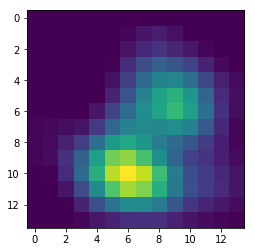

In [63]:
heatmap = np.maximum(0, heatmap)
heatmap /= heatmap.max()

plt.imshow(heatmap)

Let's bring the heatmap up to the dimensionality of our image.

In [64]:
heatmap = skimage.transform.resize(heatmap, img.shape)

/home/radek/anaconda3/envs/fastai/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/radek/anaconda3/envs/fastai/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


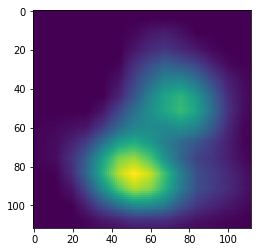

In [65]:
plt.imshow(heatmap)

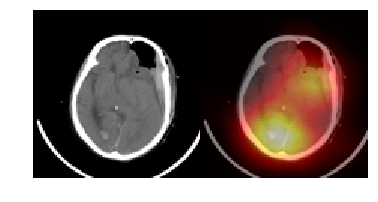

In [66]:
axes = plt.subplots(1,2)
axes[1][0].imshow(img)
axes[1][0].axis('off')

axes[1][1].imshow(img)
axes[1][1].imshow(heatmap, alpha=0.5, cmap='hot')
axes[1][1].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)